Plans for this model:


*   LLM - openAI

---

Steps for the model:


1.   Open all of the gold data files. Open the .ann version first so we can gather the metadata, then jump to the txt file so we can obtain the context window for the mode. Save this in a dict data structure.
2.   Prompt for LLM with the given context and see if it matches the annotation from the dict from the annotation file. Save this in a Counter.
3.   Collect the statistics from our model using the Counter variable.











In [ ]:
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.3/320.3 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.4 MB/s eta 0:00:00


In [ ]:
import os

# get the current working directory
current_working_directory = os.getcwd()

# print output to the console
print(current_working_directory)

/content


In [ ]:
#install OpenAi and get it setup
from openai import OpenAI
client = OpenAI(api_key="")

In [ ]:
# upload our shared google drive for the gold data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ensure that the two files stored are Gold Data 1 and Gold Data 2
!ls /content/drive/Shareddrives/Folklore/'Folklore and Fauna Project'/data/'Gold Data'
print("=" * 50)
# ensure Gold Data 1 is organized properly
!ls /content/drive/Shareddrives/Folklore/'Folklore and Fauna Project'/data/'Gold Data'/'Gold Data 1'
print("=" * 50)
# ensure Gold Data 2 is organized properly
!ls /content/drive/Shareddrives/Folklore/'Folklore and Fauna Project'/data/'Gold Data'/'Gold Data 2'
print("=" * 50)

'Gold Data 1'  'Gold Data 2'
annotation.conf  Cherokee  Filipino  Japanese  Maori  Seneca
Cherokee  Filipino  Japanese  Maori  Seneca


In [ ]:
# this is the string that we will always input into the system to solicit our output
system_role_content = "You will be provided with an animal or plant. State whether the animal is a protagonist, antagonist, or default given the story and just print the word protagonist, antagonist, or default."
system_alignment_content = "You will be provided with an animal or plant. State whether the animal is a good, evil, or neutral given the story and just print the word good, evil, or neutral."

# this is the character string span size for the context window
context_window_size = 500

In [ ]:
import os

# loop through the document to get the path of each document and its annotations
# save the paths in the following dict: {annotated_doc_path: textfile_doc_path}

#all my gold data is also in 1 so I think it's a-ok
ann_dir = "/content/drive/Shareddrives/Folklore/Folklore and Fauna Project/data/Gold Data/Gold Data 1"
dict_of_paths = {}

for root, dirs, files in os.walk(ann_dir):
  for file in files:
    if file.endswith(".txt"):
      filename = os.path.join(root, file)
      matching_txt_file = filename[:-4] + '.ann'
      dict_of_paths[matching_txt_file] = filename

print(dict_of_paths)

{'/content/drive/Shareddrives/Folklore/Folklore and Fauna Project/data/Gold Data/Gold Data 1/Cherokee/BoyAndTheRattlesnakeStory.ann': '/content/drive/Shareddrives/Folklore/Folklore and Fauna Project/data/Gold Data/Gold Data 1/Cherokee/BoyAndTheRattlesnakeStory.txt', '/content/drive/Shareddrives/Folklore/Folklore and Fauna Project/data/Gold Data/Gold Data 1/Cherokee/HowTheHoneyBeeGotTheirStinger.ann': '/content/drive/Shareddrives/Folklore/Folklore and Fauna Project/data/Gold Data/Gold Data 1/Cherokee/HowTheHoneyBeeGotTheirStinger.txt', '/content/drive/Shareddrives/Folklore/Folklore and Fauna Project/data/Gold Data/Gold Data 1/Cherokee/HowTheDeerGotHisHorns.ann': '/content/drive/Shareddrives/Folklore/Folklore and Fauna Project/data/Gold Data/Gold Data 1/Cherokee/HowTheDeerGotHisHorns.txt', '/content/drive/Shareddrives/Folklore/Folklore and Fauna Project/data/Gold Data/Gold Data 1/Cherokee/HowThePartridgeGotHisWhistle.ann': '/content/drive/Shareddrives/Folklore/Folklore and Fauna Project/

In [ ]:
def dict_of_annotations(path):
  '''
  path: filepath for the .ann file
  return: a dictionary for the annotation file that includes all of the flora and fauna in the file,
  and a tuple of their motifs and a span of the tag in order to obtain a context window
  return: {flora/fauna: tuple(protag/antag, good/evil, span)}
  '''
  file_dict = {}  # dict to return
  tag_dict = {}  # dict mapping each tag to its flora/fauna
  tag_spans = {} # dict of all of the spans for each tag
  motif_tuple = ()  # tuple of motifs for each flora/fauna
  prev_attributed_tag = None # saving the tag aka flora/fauna that has the attribute in case the next attribute doesn't match

  # open the file
  with open(path, 'r') as file:
    for line in file:
      if line[0] == 'T':
        # add all the flora/fauna to the dictionary
        file_dict[line.split()[1]] = None
        tag_dict[line.split()[0]] = line.split()[1]
        tag_spans[line.split()[0]] = (line.split()[2], line.split()[3])

      elif line[0] == 'A':
        # map the motifs as tuples (protag/antag, good/evil) to their animal
        curr_attributed_tag = line.split()[2]
        # edgecase: if the annotator only added one of the two motifs for a tag
        if prev_attributed_tag != curr_attributed_tag and len(motif_tuple) != 0:
          motif_tuple += (None, tag_spans[prev_attributed_tag])
          file_dict[tag_dict[prev_attributed_tag]] = motif_tuple
          motif_tuple = ()
        # if the tuple for this flora/fauna is currently empty
        if len(motif_tuple) == 0:
          motif_tuple = (line.split()[-1],)
        # if it just has one, add the good/evil feature, add the tuple to the dict then wipe the tuple
        elif len(motif_tuple) == 1:
          motif_tuple += (line.split()[-1],)
          motif_tuple += (tag_spans[curr_attributed_tag],)
          file_dict[tag_dict[curr_attributed_tag]] = motif_tuple
          motif_tuple = ()
        prev_attributed_tag = curr_attributed_tag
    return file_dict

In [ ]:
def context_windows(path, animal_attribute):
  '''
  given the path of the .txt file and the animal attributes from the corresponding .ann file
  return the modified animal_attributes as {flora/fauna: tuple(protag/antag, good/evil, context window)}
  '''
  # FIGURE OUT THE EDGECASE WHERE THERE ARE NO ANIMAL_ATTRIBUTES OR SOMETHING IS NONE
  if animal_attribute == None:
    return None

  # getting the text from the txt file
  with open(path, 'r') as file:
    text = ''
    for line in file:
      text = text + line

  # for each flora/fauna in the dict of flora/fauna
  for key in animal_attribute:
    if animal_attribute[key] is not None:
      # finding the span
      span = animal_attribute[key][2]
      # creating the initial and final indices for the context window
      initial_index = int(span[0]) - context_window_size
      final_index = int(span[1]) + context_window_size
      # later, we might want consider shifting the entire context window
      # currently, this just shortens the window if the tag is near the beginning or end of the text
      if initial_index < 0:
        initial_index = 0
      if final_index >= len(text):
        final_index = len(text) - 1

      # get the context in terms of characters
      context = ''
      for char in range(initial_index, final_index):
        # CONSIDER FINDING A WAY TO DO THIS ALONG WORDS SO WE DON'T HAVE CONTEXTS LIKE "his is a contex"
        context = context + text[char]

      animal_attribute[key] = animal_attribute[key][:-1] + (context, )
  return animal_attribute




In [ ]:
# now that we have the following data strucutre: {flora/fauna: tuple(protag/antag, good/evil, context window)}
# we can feed this into our model

def get_alignment_or_role(annotation_goal, character, context):
  '''
  Given the context window and the animal
  returns what the model predicts
  '''

  #print(annotation_goal, character, context)
  response = client.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=[
    {
      "role": "system",
      "content": annotation_goal
    },
    {
      "role": "user",
      "content": f"plant/animal: {character}. Story: {context}"
    }
  ],
  temperature=0.7,
  max_tokens=64,
  top_p=1
)

  result = response.choices[0].message.content

  if len(result.split()) == 1:
    return result
  else:
    # FIND A BETTER WAY TO DEBUG CASES WHERE THE MODEL PRODUCES SENTENCES LATER!
    return result.split()[0]

In [ ]:
# version 2 of output stream
# prepping metrics for stats
predicted_alignment_list, actual_alignment_list, predicted_role_list, actual_role_list, culture_list = [], [], [], [], []
cultures = ["Cherokee", 'Seneca', "Japanese", "Maori", "Filipino"]

for file in dict_of_paths:
  animal_attributes = dict_of_annotations(file)
  # converting to {flora/fauna: tuple(protag/antag, good/evil, context window)}
  new_attributes = context_windows(dict_of_paths[file], animal_attributes)
  #finding culture of origin


  # have the model predict a result of each non-None attribute
  for character in new_attributes:
    character_tuple = new_attributes[character]
    # CURRENTLY NOT DEALING WITH ALL UN-ANNOTATED TAGS
    #ok, so this line doesn't work but I don't want to fix the tabs rn -- Autumn

    if character_tuple is not None:
        # testing role and calibrating for sklearn
        predicted_role = get_alignment_or_role(system_role_content, character, character_tuple[2])
        # testing alignment
        predicted_alignment = get_alignment_or_role(system_alignment_content, character, character_tuple[2])

        #Look, I was hitting all the bases w/hardcoding out the bug, it was SO annoying - Autumn
        if predicted_alignment != None:
          if predicted_role != None:
            if character_tuple[0] != None:
              if character_tuple[1] != None:
                # tabulating predicted and actual in cases where None is not present
                predicted_alignment_list.append(predicted_alignment.lower())
                actual_alignment_list.append(character_tuple[1].lower())
                predicted_role_list.append(predicted_role.lower())
                actual_role_list.append(character_tuple[0].lower())
                file_name = file
                for culture in cultures:
                  if file_name.find(culture) != -1:
                    culture_list.append(culture)

                # print("predicted alignment: " + str(predicted_alignment_list))
                # print("actual alignment: " + str(actual_alignment_list))
                # print("predicted role: " + str(predicted_role_list))
                # print("actual role: " + str(actual_role_list))

              #This was still throwing a Nonetype for some reason
              #if predicted_role != character_tuple[0] or predicted_alignment != character_tuple[1]:
                # print('\n' + "predicted role: " + predicted_role + " actual role: " + character_tuple[0])
                # print("predicted alignment: " + predicted_alignment + " actual alignment: " + character_tuple[1] + '\n')

print("predicted alignment: " + str(predicted_alignment_list))
print("actual alignment: " + str(actual_alignment_list))
print("predicted role: " + str(predicted_role_list))
print("actual role: " + str(actual_role_list))

predicted alignment: ['neutral', 'good', 'good', 'good', 'neutral', 'neutral', 'neutral', 'neutral', 'evil', 'neutral', 'neutral', 'neutral', 'neutral', 'evil', 'evil', 'neutral', 'neutral', 'neutral', 'good', 'neutral', 'neutral', 'neutral', 'neutral', 'good', 'neutral', 'good', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'good', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'good', 'neutral', 'neutral', 'good', 'neutral', 'neutral', 'neutral', 'evil', 'neutral', 'neutral', 'evil', 'neutral', 'good', 'good', 'neutral', 'neutral', 'neutral', 'evil', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'evil', 'neutral', 'neutral', 'neutral', 'neutral', 'evil', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'evil', 'neutral', 'neutral', 'neutral', 'evil', 'neutral', 'neutral', 'evil', 'neutral', 'neutral', 'good', 'good', 'neutral', 'neutral', 'neutral', 'neutral', 'good', 'good', 'neutral', 'neutral', 

In [ ]:
# calculating statistics from previous output using predicted_alignment_list, actual_alignment_list, predicted_role_list, actual_role_list
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
from collections import Counter

# accuracy
alignment_accuracy = accuracy_score(actual_alignment_list, predicted_alignment_list)
role_accuracy = accuracy_score(actual_role_list, predicted_role_list)

# recall
alignment_recall = recall_score(actual_alignment_list, predicted_alignment_list, average='macro', zero_division=1)
role_recall = recall_score(actual_role_list, predicted_role_list, average='macro', zero_division=1)

# precision
alignment_precision = precision_score(actual_alignment_list, predicted_alignment_list, average='macro', zero_division=1)
role_precision = precision_score(actual_role_list, predicted_role_list, average='macro', zero_division=1)

# f1
alignment_f1 = f1_score(actual_alignment_list, predicted_alignment_list, average='macro', zero_division=1)
role_f1 = f1_score(actual_role_list, predicted_role_list, average='macro', zero_division=1)

# calculating the number of tags in each dataset, not including 'None' categories
actual_alignment_counts = Counter(actual_alignment_list)
actual_role_counts = Counter(actual_role_list)


cherokee_alignment = []
cherokee_predicted_alignment = []
seneca_alignment = []
seneca_predicted_alignment = []
maori_alignment = []
maori_predicted_alignment = []
japanese_alignment = []
japanese_predicted_alignment = []
filipinio_alignment = []
filipino_predicted_alignment = []

# culture of origin statistics
for i in range(len(culture_list)):
  if culture_list[i] == "Cherokee":
    cherokee_alignment.append(actual_alignment_list[i])
    cherokee_predicted_alignment.append(predicted_alignment_list[i])
  if culture_list[i] == "Seneca":
    seneca_alignment.append(actual_alignment_list[i])
    seneca_predicted_alignment.append(predicted_alignment_list[i])
  if culture_list[i] == "Maori":
    maori_alignment.append(actual_alignment_list[i])
    maori_predicted_alignment.append(predicted_alignment_list[i])
  if culture_list[i] == "Japanese":
    japanese_alignment.append(actual_alignment_list[i])
    japanese_predicted_alignment.append(predicted_alignment_list[i])
  if culture_list[i] == "Filipino":
    filipinio_alignment.append(actual_alignment_list[i])
    filipino_predicted_alignment.append(predicted_alignment_list[i])

cherokee_alignment_accuracy = accuracy_score(cherokee_alignment, cherokee_predicted_alignment)
seneca_alignment_accuracy = accuracy_score(seneca_alignment, seneca_predicted_alignment)
maori_alignment_accuracy = accuracy_score(cherokee_alignment, cherokee_predicted_alignment)
japanese_alignment_accuracy = accuracy_score(seneca_alignment, seneca_predicted_alignment)
filipino_alignment_accuracy = accuracy_score(seneca_alignment, seneca_predicted_alignment)
print(cherokee_alignment_accuracy)
print(seneca_alignment_accuracy)
print(maori_alignment_accuracy)
print(japanese_alignment_accuracy)
print(filipino_alignment_accuracy)



# roles of each animal depending on culture of origin

# accuracy/recall/precision of each depending on culture of origin

# statistics on the common tags were, as well as number of tags including 'None' categories
# also figuring out the common motifs for each tag
all_tags = Counter()
all_tags_alignments = Counter()
all_tags_roles = Counter()
tags_with_none = Counter()
all_alignments_plus_none = Counter()
all_roles_plus_none = Counter()
cherokee_tags = Counter()
japanese_tags = Counter()
filipino_tags = Counter()
maori_tags = Counter()
seneca_tags = Counter()
for file in dict_of_paths:
  # create a datastrucutre using {flora/fauna: tuple(protag/antag, good/evil, context window)} for tags in every file
  animal_attributes = dict_of_annotations(file)
  all_tags.update(Counter(animal_attributes.keys()))
  for culture in culture_list:
    if file_name.find(culture) != 0:
      for tag in animal_attributes:
        if animal_attributes[tag] is not None:
          # count the tags
          all_tags_alignments.update({(tag, animal_attributes[tag][0]):1})
          all_tags_roles.update({(tag, animal_attributes[tag][1]):1})
          if culture == "Maori":
            maori_tags.update({tag: 1})
            #maori_roles.update(animal_attributes[tag][1])
          if culture == "Seneca":
            seneca_tags.update({tag: 1})
          if culture == "Cherokee":
            cherokee_tags.update({tag: 1})
          if culture == "Filipino":
            filipino_tags.update({tag: 1})
          if culture == "Japanese":
            japanese_tags.update({tag: 1})


          # count all the alignments and roles
          if animal_attributes[tag][0] != None:
            all_roles_plus_none.update({animal_attributes[tag][0]: 1})
          else:
            all_roles_plus_none.update({"None": 1})
          if animal_attributes[tag][1] != None:
            all_alignments_plus_none.update({animal_attributes[tag][1]: 1})
          else:
            all_alignments_plus_none.update({"None": 1})
        else:
          tags_with_none.update({tag: 1})

print("alignment_accuracy: " + str(alignment_accuracy))
print("role_accuracy: " + str(role_accuracy))
print("alignment_recall: " + str(alignment_recall))
print("role_recall: " + str(role_recall))
print("alignment_precision: " + str(alignment_precision))
print("role_precision: " + str(role_precision))
print("alignment_f1: " + str(alignment_f1))
print("role_f1: " + str(role_f1))
print()
print("count of tags in the dataset")
print(actual_alignment_counts)
print(actual_role_counts)
print()
print("including none variables:")
print(tags_with_none)
print(all_alignments_plus_none)
print(all_roles_plus_none)
print()
print("count of all tags")
print(all_tags)
print(all_tags_alignments)
print(all_tags_roles)
print()
print("culture counts")
print("cherokee" + str(cherokee_tags.most_common(20)))
print("jpn" + str(japanese_tags.most_common(20)))
print("filipino" + str(filipino_tags.most_common(20)))
print("maori" + str(maori_tags.most_common(20)))
print("seneca" + str(seneca_tags.most_common(20)))

0.65625
0.6804123711340206
0.65625
0.6804123711340206
0.6804123711340206
alignment_accuracy: 0.6898263027295285
role_accuracy: 0.40198511166253104
alignment_recall: 0.5177328843995511
role_recall: 0.7993090794415298
alignment_precision: 0.518446455505279
role_precision: 0.16450889822443376
alignment_f1: 0.5138861656231112
role_f1: 0.13071391884951206

count of tags in the dataset
Counter({'neutral': 297, 'good': 66, 'evil': 40})
Counter({'default': 302, 'protagonist': 66, 'antagonist': 35})

including none variables:
Counter({'Flower': 6851, 'Bear': 3224, 'Fish': 2418, 'Insect': 2015, 'Crop': 2015, 'Deciduous': 1612, 'Tree': 1612, 'Canine': 1209, 'Ungulate': 1209, 'Plant': 806, 'Primate': 806, 'Snake': 806, 'Mustelid': 806, 'Shrub': 806, 'Rodent': 806, 'Ciconiidae': 403, 'Testudine': 403, 'Spider': 403, 'Feline': 403, 'Bird': 403, 'Lizard': 403, 'Mcp': 403})
Counter({'Neutral': 119691, 'Good': 26598, 'Evil': 16120, 'None': 806})
Counter({'Default': 122109, 'Protagonist': 26598, 'Antago

In [ ]:
print(sum(all_tags.values()))

479


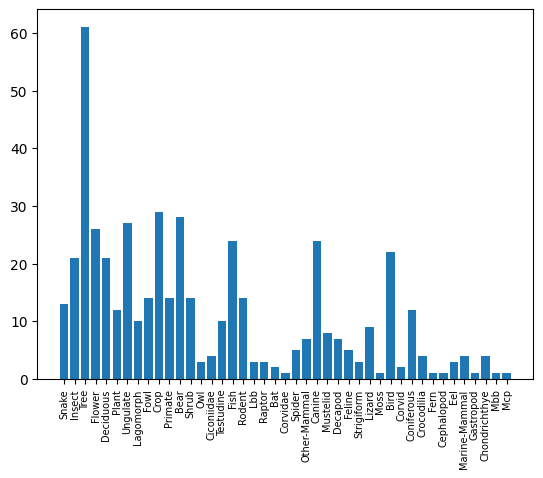

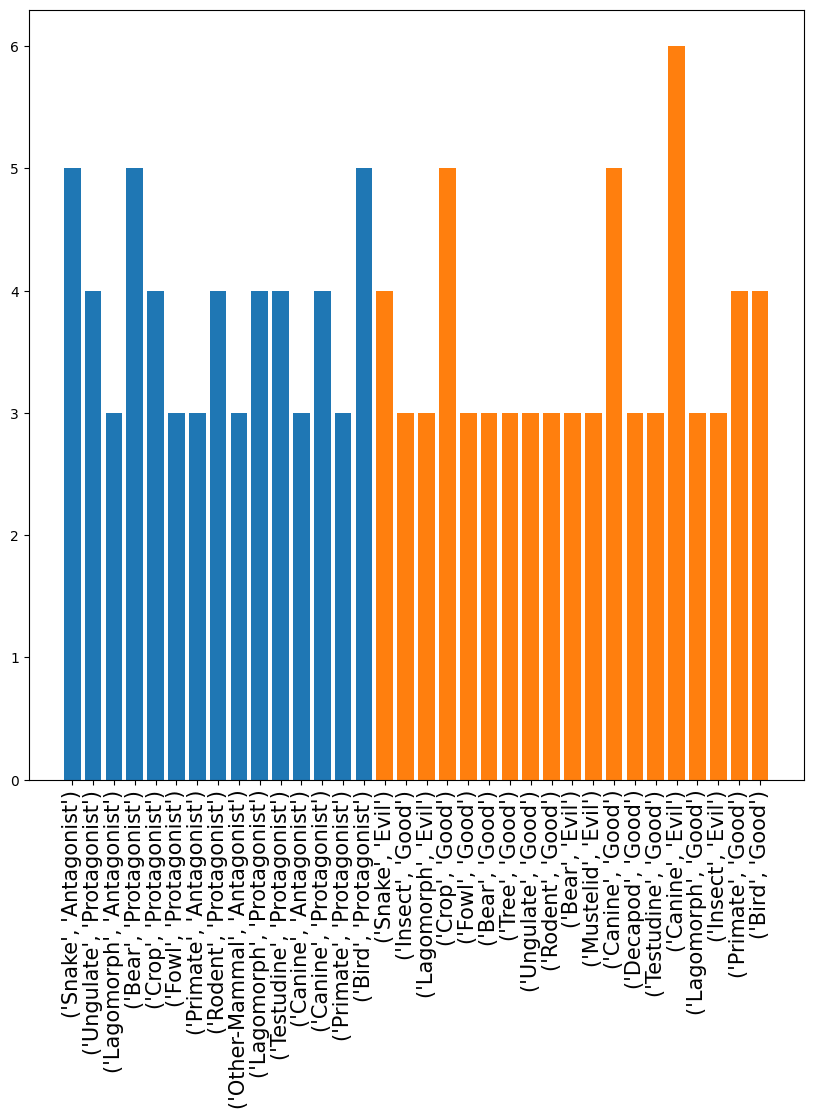

In [ ]:
# producing plots from these statistical calculations
import matplotlib.pyplot as plt

# all tags
tag_distribution = plt.figure(1)
tag_distribution = plt.bar(list(all_tags.keys()), list(all_tags.values()))
# Adjust x label to make it visible
plt.xticks(rotation='vertical')
plt.xticks(fontsize=7)

# motifs for each tag
alignments = plt.figure(2, figsize=(10, 10))
# filtering all_tags_alignments if it has fewer than 5 of a given count
filtered_counter = {key: count for key, count in all_tags_alignments.items() if key[1] != 'Default' and count > 2}
x = [str(key) for key in list(filtered_counter.keys())]
alignments = plt.bar(x, list(filtered_counter.values()))
# Adjust label and size to make it visible
plt.xticks(rotation='vertical')
plt.xticks(fontsize=15)

roles = plt.figure(2, figsize=(10, 10))
# filtering all_tags_alignments if it has fewer than 5 of a given count
filtered_counter = {key: count for key, count in all_tags_roles.items() if key[1] != 'Neutral' and count > 2}
x = [str(key) for key in list(filtered_counter.keys())]
alignments = plt.bar(x, list(filtered_counter.values()))
# Adjust label and size to make it visible
plt.xticks(rotation='vertical')
plt.xticks(fontsize=15)


plt.show()

In [ ]:
#fml it didn't save previous iteration with the counters
# version 1 of output stream

from re import I
# now we have to go through and predict each result, and see how it compares to our model
from collections import Counter
total_stories_counter = 0
total_attribute_counter = 0
total_roles = 0
total_alignments = 0
accurate_predicted_roles = 0
accurate_predicted_alignments = 0
accurate_predicted_roles_and_alignments = 0
roles = ["protagonist", "antagonist", "neutral"]
alignments = ['good', 'evil', 'neutral']


#AUTUMN'S TASKS/IDEAS
#todo -> counters for all the flora/fauna, what they're tagged with, & how often --> look for trends
#todo -> what is mistagged the most often? What animals show up most often?
#todo -> do certain animals/species only show up in certain cultures
#todo -> fix flowers out of all of the data sets (roses. Just fix the roses)
#todo -> try the same modeling of flora/fauna w/country of origin & naive bayes now that we have more



#maybe not for this iteration of the project
#todo -> fix the parrots
#todo -> add the animals autumn commented on



#For recall and precision  --> replace with scikit learn
roles_counter_trueP = Counter()
roles_counter_trueN = Counter()
roles_counter_falseP = Counter()
roles_counter_falseN = Counter()
alignments_counter_trueP = Counter()
alignments_counter_trueN = Counter()
alignments_counter_falseP = Counter()
alignments_counter_falseN = Counter()



for file in dict_of_paths:
  total_stories_counter += 1
  animal_attributes = dict_of_annotations(file)
  # converting to {flora/fauna: tuple(protag/antag, good/evil, context window)}
  new_attributes = context_windows(dict_of_paths[file], animal_attributes)

  # have the model predict a result of each non-None attribute
  for character in new_attributes:
    character_tuple = new_attributes[character]
    total_attribute_counter += 1
    # CURRENTLY NOT DEALING WITH ALL UN-ANNOTATED TAGS

    #ok, so this line doesn't work but I don't want to fix the tabs rn -- Autumn
    if character_tuple is not None:
        # we can make this more formal statistics later

        # testing role
        predicted_role = get_alignment_or_role(system_role_content, character, character_tuple[2])
        # testing alignment
        predicted_alignment = get_alignment_or_role(system_alignment_content, character, character_tuple[2])

        #Look, I was hitting all the bases w/hardcoding out the bug, it was SO annoying - Autumn
        if predicted_alignment != None:
          if predicted_role != None:
            if character_tuple[0] != None:
              if character_tuple[1] != None:
                total_roles += 1
                total_alignments += 1

              #This was still throwing a Nonetype for some reason
              #if predicted_role != character_tuple[0] or predicted_alignment != character_tuple[1]:
                print('\n' + "predicted role: " + predicted_role + " actual role: " + character_tuple[0])
                print("predicted alignment: " + predicted_alignment + " actual alignment: " + character_tuple[1] + '\n')

                #didn't have time to do scikit, so just doing some simple counters to find total # of correctly identified roles
                if predicted_role == character_tuple[0].lower():
                  accurate_predicted_roles += 1
                if predicted_alignment == character_tuple[1].lower():
                  accurate_predicted_alignments += 1

                for role in roles:
                  i = roles.index(role)
                  if predicted_role == roles[i]:
                    if predicted_role == character_tuple[0].lower():
                      roles_counter_trueP[role] += 1
                  if predicted_role == roles[i]:
                    if predicted_role != character_tuple[0].lower:
                      roles_counter_falseP[role] += 1
                  if predicted_role != roles[i]:
                    if predicted_role != character_tuple[0].lower:
                      roles_counter_trueN[role] += 1
                  if predicted_role != roles[i]:
                    if predicted_role == character_tuple[0].lower:
                      roles_counter_falseN[role] += 1

                for alignment in alignments:
                  j = alignments.index(alignment)
                  if predicted_alignment == alignments[j]:
                     if character_tuple[0].lower():
                        roles_counter_trueP[alignment] += 1
                  if predicted_alignment == alignments[j]:
                    if predicted_alignment != character_tuple[0].lower:
                      roles_counter_falseP[alignment] += 1
                  if predicted_alignment != alignments[j]:
                    if predicted_alignment != character_tuple[0].lower:
                      roles_counter_trueN[alignment] += 1
                  if predicted_alignment != alignments[j]:
                    if predicted_alignment == character_tuple[0].lower:
                      roles_counter_falseN[alignment] += 1




        # if predicted_role != character_tuple[0] or predicted_alignment != character_tuple[1]:
        #   print("predicted role: " + predicted_role + " actual role: " + character_tuple[0])
        #   print("predicted alignment: " + predicted_alignment + " actual alignment: " + character_tuple[1])

print("accurately predicted alignments " + str(accurate_predicted_alignments/total_alignments))
print("accurately predicted roles " + str(accurate_predicted_roles/total_roles))
print("Total stories " + str(total_stories_counter))
print("Total attributes " + str(total_attribute_counter))

k = 0
l = 0


#role_precision =
#role_recall =
#alignments precision =
#role precision =


You will be provided with an animal or plant. State whether the animal is a protagonist, antagonist, or default given the story and just print the word protagonist, antagonist, or default. Snake He came all the way down the mountain holding the snake carefully and took it to his home to give him som
You will be provided with an animal or plant. State whether the animal is a good, evil, or neutral given the story and just print the word good, evil, or neutral. Snake He came all the way down the mountain holding the snake carefully and took it to his home to give him som

predicted role: Protagonist actual role: Antagonist
predicted alignment: neutral actual alignment: Evil

You will be provided with an animal or plant. State whether the animal is a protagonist, antagonist, or default given the story and just print the word protagonist, antagonist, or default. Insect as "sweet" to the taste.
So, the Creator sent the Bee, but the Bee had no stinger. Down came the Bee an
You will be provid

KeyboardInterrupt: 

In [ ]:


# tests
for file in dict_of_paths:
  animal_attributes = dict_of_annotations(file)
  new_attributes = context_windows(dict_of_paths[file], animal_attributes)
  print(new_attributes)

{'Snake': ('Antagonist', 'Evil', 'He came all the way down the mountain holding the snake carefully and took it to his home to give him som')}
{'Insect': ('Protagonist', 'Good', 'as "sweet" to the taste.\nSo, the Creator sent the Bee, but the Bee had no stinger. Down came the Bee an'), 'Tree': ('Default', 'Neutral', 'tinger. Down came the Bee and it found a suitable tree in which,\nthey could build their hive, live in, p'), 'Flower': ('Default', 'Good', 'e. The Flower People began to spread all types of flowers across the land giving the Bees greater access an'), 'Deciduous': None, 'Plant': None}
{'Ungulate': ('Protagonist', 'Neutral', 'In the beginning the Deer had no horns, but his head was smooth just like a'), 'Lagomorph': ('Antagonist', 'Evil', 'just like a doe’s.  He was a great runner and the Rabbit was a great jumper, and the animals were all curi')}
{'Tree': ('Default', 'Neutral', ', gave one long whistle, and flew to the top of a tree, leaving the poor Terrapin to look after 

In [ ]:
# tests

for file in dict_of_paths:
  animal_attributes = dict_of_annotations(file)
  print(animal_attributes)

{'Snake': ('Antagonist', 'Evil', ('912', '917'))}
{'Insect': ('Protagonist', 'Good', ('221', '224')), 'Tree': ('Default', 'Neutral', ('296', '300')), 'Flower': ('Default', 'Good', ('955', '962')), 'Deciduous': None, 'Plant': None}
{'Ungulate': ('Protagonist', 'Neutral', ('21', '25')), 'Lagomorph': ('Antagonist', 'Evil', ('114', '120'))}
{'Tree': ('Default', 'Neutral', ('993', '997')), 'Fowl': ('Antagonist', 'Evil', ('1155', '1161'))}
{'Ungulate': None, 'Lagomorph': None}
{'Crop': ('Default', 'Neutral', ('693', '698')), 'Primate': ('Default', 'Neutral', ('1956', '1961')), 'Bear': ('Protagonist', 'Neutral', ('2135', '2140'))}
{'Shrub': None, 'Ungulate': None, 'Plant': None, 'Owl': None, 'Bear': None, 'Crop': None, 'Fowl': None, 'Deciduous': None, 'Fish': None}
{'Ciconiidae': None, 'Testudine': None, 'Flower': None, 'Primate': None}
{'Shrub': None, 'Fish': None, 'Crop': None, 'Plant': None}
{'Fish': ('Default', 'Neutral', ('33', '39')), 'Plant': ('Default', 'Good', ('6876', '6881')), 'Ins

In [ ]:
#This could be fun if we wanted to ask a bunch of questions I think
from openai import OpenAI
client = OpenAI(api_key="...")
stream = client.chat.completions.create(
    model="gpt-4",
    messages=[{"role": "user", "content": "What creatures are most commonly predicted as evil?"}],
    messages=[{"role": "user", "content": "What creatures are most commonly predicted as good?"}],
    messages=[{"role": "user", "content": "What are the most common creatures in our stories?"}],
    stream=True,
)
for part in stream:
    print(part.choices[0].delta.content or "")